In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


# Comprehensive data exploration 

Loading data from first_100000_rows.csv...
Analyzing 100000 rows from column 'content'...
Performing word frequency analysis...
Processing with config: raw...
Processing with config: no_stopwords...
Processing with config: stemmed...
Processing with config: no_stopwords_stemmed...

=== ANALYSIS SUMMARY ===
Total rows analyzed: 100000
Total URLs found: 71778
Total dates found: 44928
Total numeric values found: 1083696

Top 100 words (raw):
the: 3311147
of: 1625516
to: 1587834
and: 1522336
in: 1079206
that: 753702
is: 720147
for: 546030
it: 480465
on: 440785
are: 374059
as: 364494
with: 359936
this: 355530
by: 300319
be: 299018
you: 298814
was: 286504
have: 271039
not: 253377
from: 252878
at: 241027
we: 234473
he: 231101
they: 226992
or: 212948
has: 205344
but: 205040
an: 201095
will: 183425
his: 182897
their: 168392
all: 166165
who: 157763
more: 153727
about: 147024
one: 146281
can: 139491
trump: 136418
what: 135591
if: 134799
there: 126631
your: 126006
so: 122417
which: 122250
our: 122

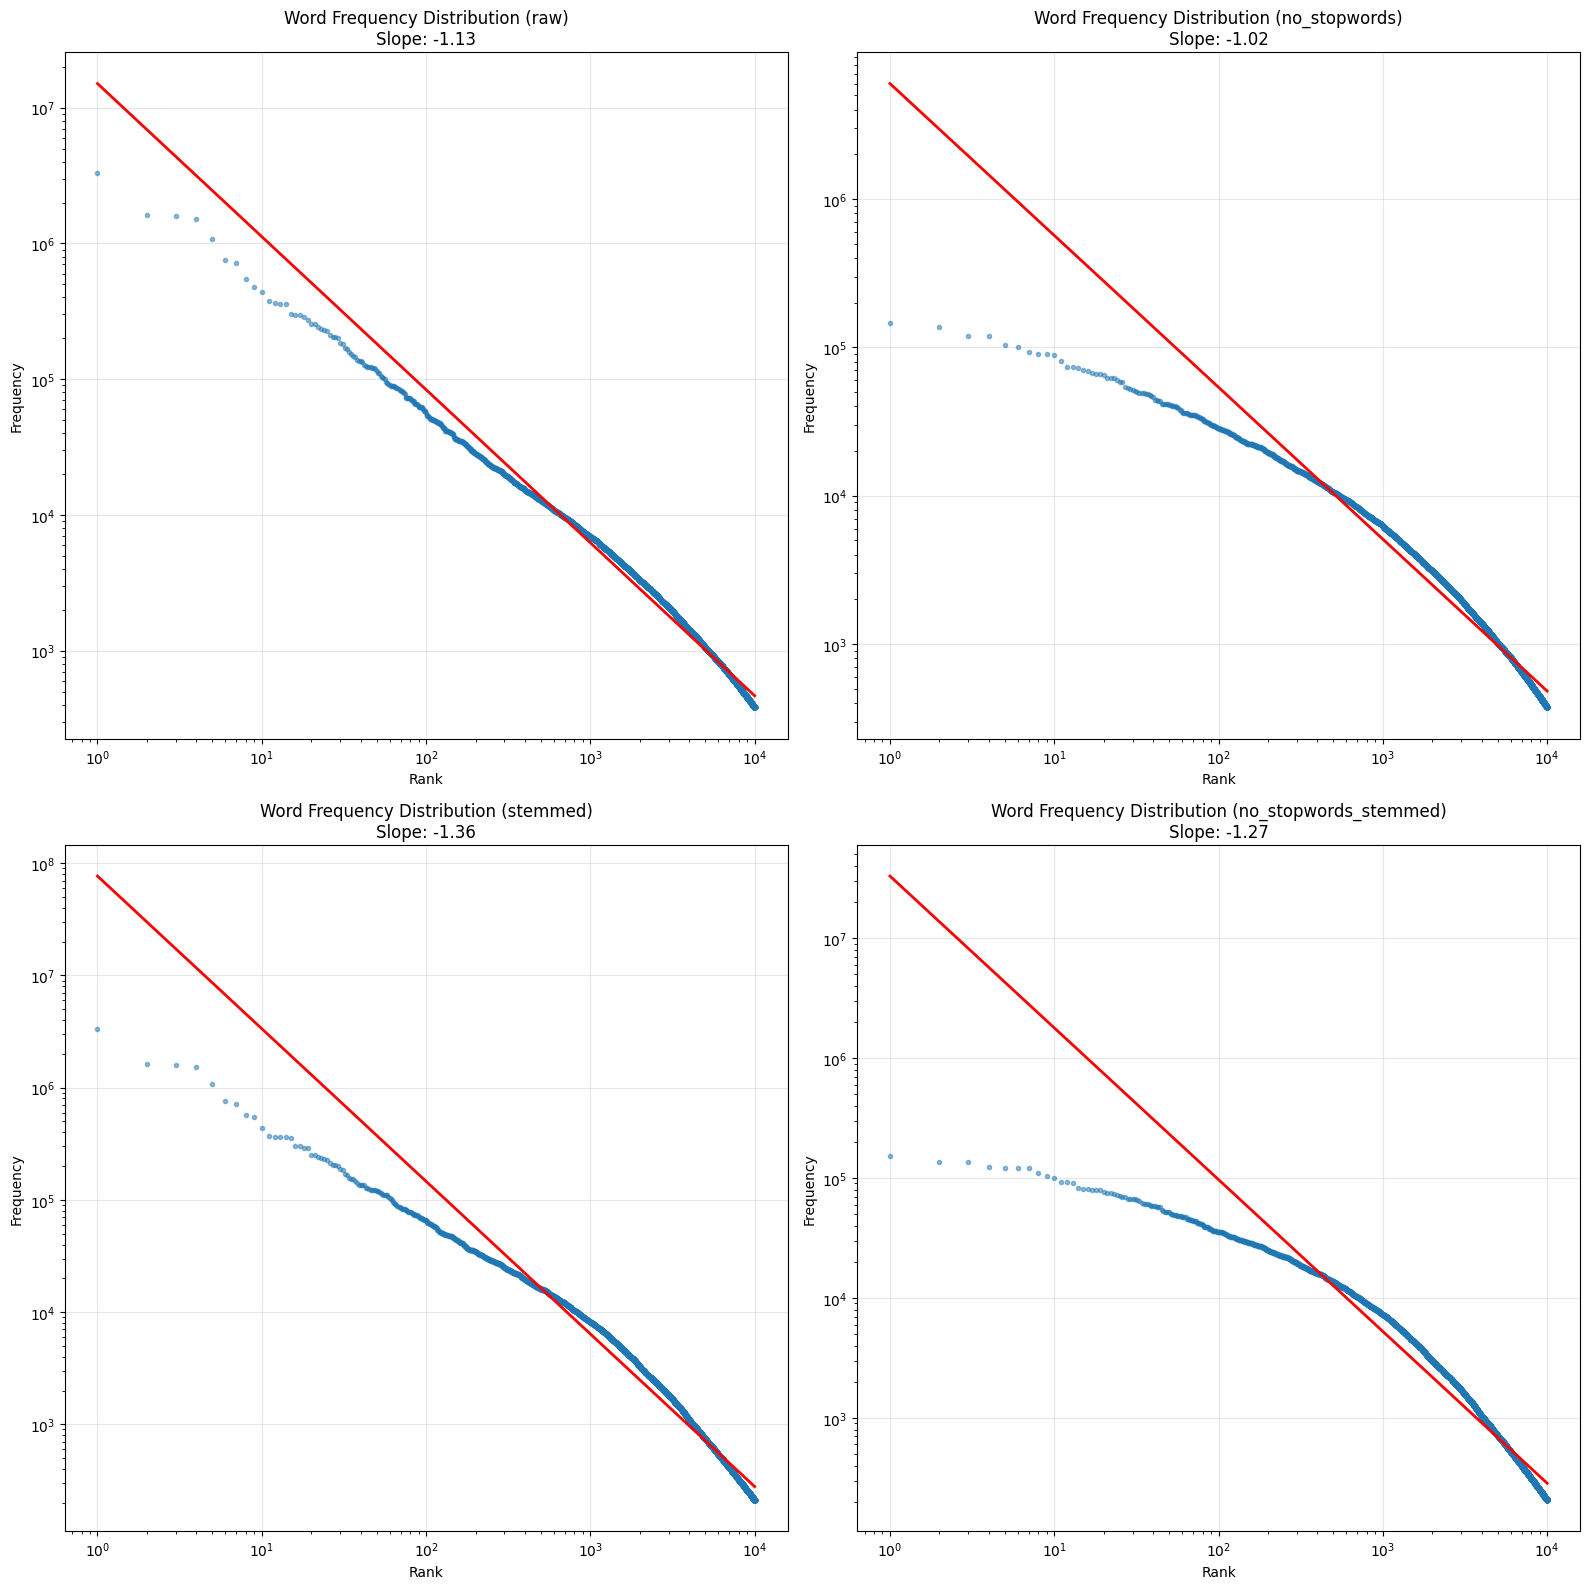

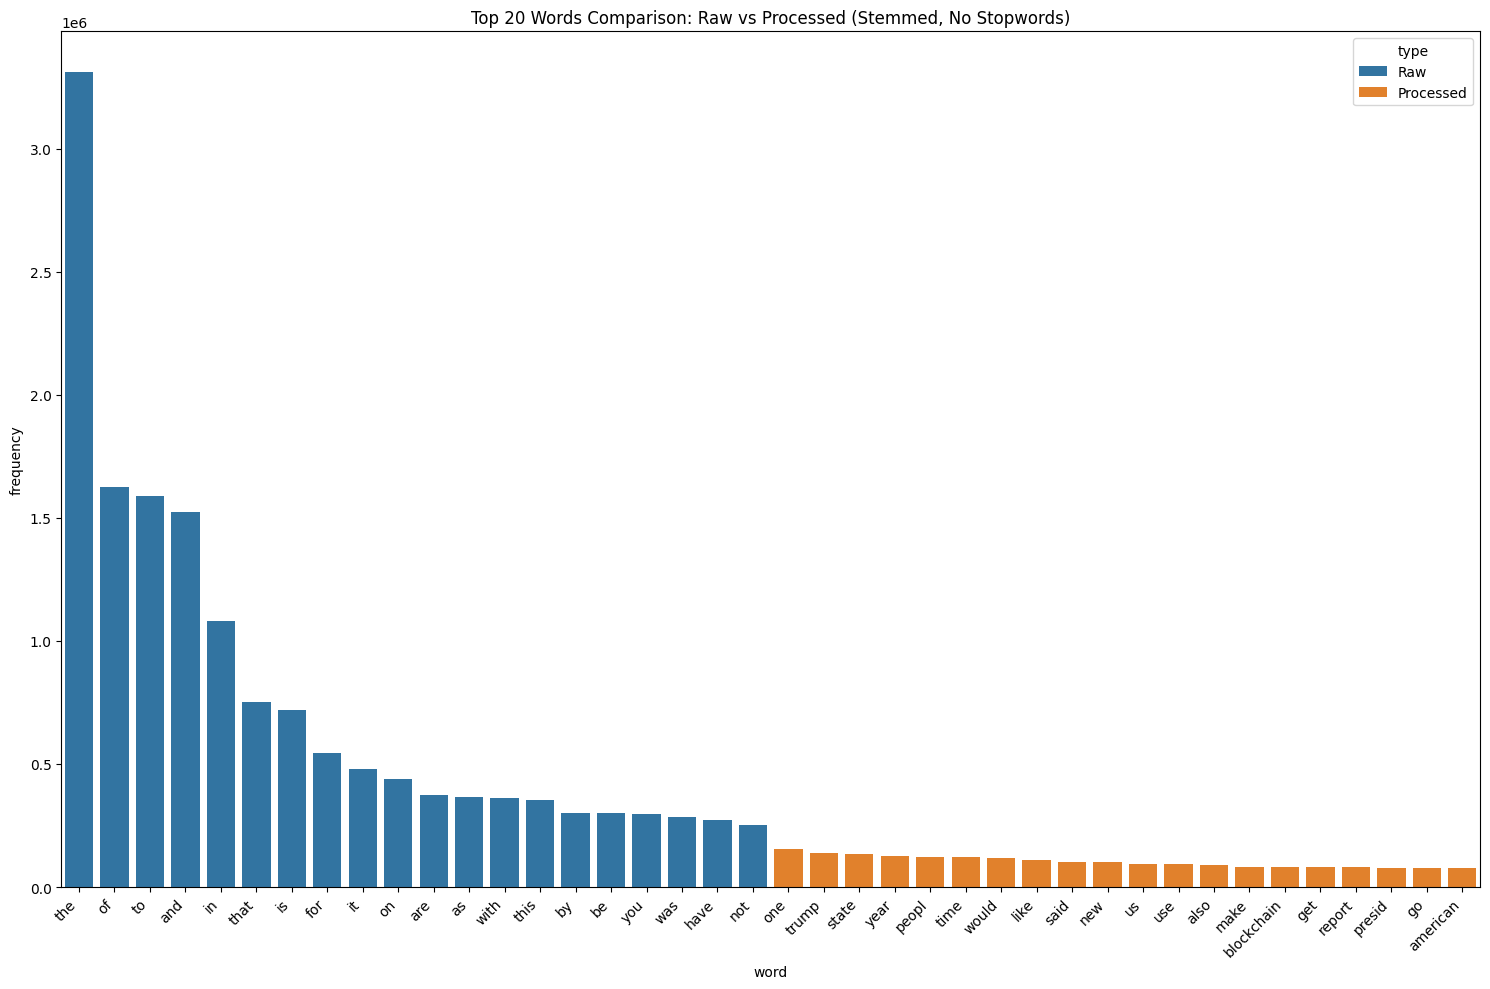

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns


try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    NLTK_AVAILABLE = True
except Exception as e:
    print(f"Warning: NLTK setup failed: {e}")
    print("Falling back to basic tokenization for word analysis")
    NLTK_AVAILABLE = False

def analyze_csv_content(csv_file_path, content_column='content'):
    """
    Performs comprehensive analysis on the content column of a CSV file containing the first 100000 rows of the dataset.
    """
    print(f"Loading data from {csv_file_path}...")
    df = pd.read_csv(csv_file_path)
    if content_column not in df.columns:
        raise ValueError(f"Column '{content_column}' not found in the CSV file.")
    
    #Extracting content column and ensuring it's string type
    df[content_column] = df[content_column].astype(str)
    contents = df[content_column].tolist()
    
    print(f"Analyzing {len(contents)} rows from column '{content_column}'...")
    
    # Task 1: Count URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    url_counts = [len(url_pattern.findall(text)) for text in contents]
    total_urls = sum(url_counts)
    
    # Task 2: Count dates
    # This pattern aims to catch common date formats: MM/DD/YYYY, DD/MM/YYYY, YYYY-MM-DD, etc.
    date_pattern = re.compile(r'\b(\d{1,4}[/-]\d{1,2}[/-]\d{1,4}|\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\.?\s+\d{2,4})\b')
    date_counts = [len(date_pattern.findall(text)) for text in contents]
    total_dates = sum(date_counts)
    
    # Task 3: Count numeric values (excluding dates and parts of URLs)
    # First, remove URLs and dates
    cleaned_contents = [url_pattern.sub('', text) for text in contents]
    cleaned_contents = [date_pattern.sub('', text) for text in cleaned_contents]
    
    # Then count standalone numbers
    number_pattern = re.compile(r'\b\d+(?:\.\d+)?\b')
    number_counts = [len(number_pattern.findall(text)) for text in cleaned_contents]
    total_numbers = sum(number_counts)
    
    # Tasks 4-6: Word frequency analysis
    print("Performing word frequency analysis...")
    
    # Function to tokenize and process text
    def process_text(text_list, remove_stopwords=False, apply_stemming=False):
        processed_words = []
        
        # Define stop words if needed
        stop_words = set()
        if NLTK_AVAILABLE and remove_stopwords:
            try:
                stop_words = set(stopwords.words('english'))
            except:
                print("Warning: Could not load NLTK stopwords. Proceeding without stopword removal.")
        
        # Process each text
        for text in text_list:
            # Remove URLs and lowercase
            text = url_pattern.sub('', text.lower())
            # Keep only alphanumeric characters and spaces
            text = re.sub(r'[^\w\s]', ' ', text)
            
            # Split into words - use NLTK if available, otherwise basic split
            if NLTK_AVAILABLE:
                try:
                    words = nltk.word_tokenize(text)
                except:
                    words = text.split()
            else:
                words = text.split()
            
            # Filter out stopwords if requested
            if remove_stopwords:
                words = [word for word in words if word not in stop_words]
            
            # Apply stemming if requested
            if NLTK_AVAILABLE and apply_stemming:
                try:
                    stemmer = PorterStemmer()
                    words = [stemmer.stem(word) for word in words]
                except:
                    print("Warning: Could not apply stemming. Proceeding without stemming.")
            
            # Filter out pure numbers and single characters
            words = [word for word in words if not word.isdigit() and len(word) > 1]
            
            processed_words.extend(words)
        
        return processed_words
    
    # Analyze with different preprocessing combinations
    analysis_configs = [
        {'stopwords': False, 'stemming': False, 'label': 'raw'},
        {'stopwords': True, 'stemming': False, 'label': 'no_stopwords'},
        {'stopwords': False, 'stemming': True, 'label': 'stemmed'},
        {'stopwords': True, 'stemming': True, 'label': 'no_stopwords_stemmed'}
    ]
    
    word_freq_results = {}
    
    for config in analysis_configs:
        print(f"Processing with config: {config['label']}...")
        processed_words = process_text(
            contents, 
            remove_stopwords=config['stopwords'], 
            apply_stemming=config['stemming']
        )
        
        # Count word frequencies
        word_counts = Counter(processed_words)
        
        # Store results
        word_freq_results[config['label']] = word_counts
    
    # Print summary of analysis
    print("\n=== ANALYSIS SUMMARY ===")
    print(f"Total rows analyzed: {len(contents)}")
    print(f"Total URLs found: {total_urls}")
    print(f"Total dates found: {total_dates}")
    print(f"Total numeric values found: {total_numbers}")
    
    # Display top 100 words for each configuration
    for config_label, word_counts in word_freq_results.items():
        print(f"\nTop 100 words ({config_label}):")
        for word, count in word_counts.most_common(100):
            print(f"{word}: {count}")
    
    # Visualize word frequencies
    plt.figure(figsize=(16, 16))
    
    for i, (config_label, word_counts) in enumerate(word_freq_results.items(), 1):
        plt.subplot(2, 2, i)
        
        # Get top 10000 words or as many as available
        top_n = min(10000, len(word_counts))
        top_words = word_counts.most_common(top_n)
        
        # Prepare data for plotting
        ranks = list(range(1, len(top_words) + 1))
        frequencies = [count for _, count in top_words]
        
        # Plot on log-log scale to observe Zipf's law
        plt.loglog(ranks, frequencies, marker='.', linestyle='none', alpha=0.5)
        
        # Add trendline
        z = np.polyfit(np.log(ranks), np.log(frequencies), 1)
        p = np.poly1d(z)
        plt.loglog(ranks, np.exp(p(np.log(ranks))), 'r-', linewidth=2)
        
        plt.title(f'Word Frequency Distribution ({config_label})\nSlope: {z[0]:.2f}')
        plt.xlabel('Rank')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("word_frequency_analysis.png", dpi=300)
    print("Word frequency plots saved as 'word_frequency_analysis.png'")
    
    # Create more detailed analysis of top words
    plt.figure(figsize=(15, 10))
    
    # Compare top 20 words across different preprocessing methods
    top_words_raw = dict(word_freq_results['raw'].most_common(20))
    top_words_processed = dict(word_freq_results['no_stopwords_stemmed'].most_common(20))
    
    
    df_raw = pd.DataFrame({'word': top_words_raw.keys(), 'frequency': top_words_raw.values(), 'type': 'Raw'})
    df_proc = pd.DataFrame({'word': top_words_processed.keys(), 'frequency': top_words_processed.values(), 'type': 'Processed'})
    df_combined = pd.concat([df_raw, df_proc])
    
    # Plot comparison
    sns.barplot(x='word', y='frequency', hue='type', data=df_combined)
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 20 Words Comparison: Raw vs Processed (Stemmed, No Stopwords)')
    plt.tight_layout()
    plt.savefig("top_words_comparison.png", dpi=300)
    print("Top words comparison plot saved as 'top_words_comparison.png'")
    
    return {
        'total_urls': total_urls,
        'total_dates': total_dates,
        'total_numbers': total_numbers,
        'word_frequencies': word_freq_results
    }

if __name__ == "__main__":
    file_path = "first_100000_rows.csv"
    results = analyze_csv_content(file_path)

# Fake/Reliable comparrison

In [ ]:
df = pd.read_csv("data_cleaned_fr_100000.csv")

#Separateing reliable and fake content
reliable_words = []
fake_words = []

for _, row in df.iterrows():
    words = row['content'].split()
    if row['type'] == 'reliable':
        reliable_words.extend(words)
    elif row['type'] == 'fake':
        fake_words.extend(words)

#Counting  word frequencies
reliable_freq = Counter(reliable_words)
fake_freq = Counter(fake_words)

# Get the most common words (top 10)
reliable_common = reliable_freq.most_common(30)
fake_common = fake_freq.most_common(30)

# Convert to lists for plotting
reliable_words, reliable_counts = zip(*reliable_common)
fake_words, fake_counts = zip(*fake_common)

# Plot bar charts
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

axes[0].bar(reliable_words, reliable_counts, color='blue')
axes[0].set_title("Most common words in reliable content")
axes[0].set_xticklabels(reliable_words, rotation=45)

axes[1].bar(fake_words, fake_counts, color='red')
axes[1].set_title("Most common words in fake content")
axes[1].set_xticklabels(fake_words, rotation=45)

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

# Reduction rate

In [ ]:

#Functions to compute reduction rate
def get_unique_words(file, column_name):
    df = pd.read_csv(file, usecols=[column_name]) 
    text = " ".join(df[column_name].astype(str))  # Converting column content to a single string
    words = re.findall(r"\b[\w'’\-]+\b", text.lower()) # Extracting words (case insensitive)
    return set(words)  # Return the unique words

def compute_reduction_rate(words_before, words_after):
    reduction = len(words_before) - len(words_after)
    reduction_rate = (reduction / len(words_before)) * 100 if words_before else 0
    return reduction, reduction_rate

file1 = "100000_raw.csv"
file2 = "data_cleaned_fr_100000.csv"
column_name = "content"  


words1 = get_unique_words(file1, column_name)
words2 = get_unique_words(file2, column_name)

# Computing reduction rate
reduction, reduction_rate = compute_reduction_rate(words2, words1)

print(f"Unique words in '{column_name}' from {file1}: {len(words1)}")
print(f"Unique words in '{column_name}' from {file2}: {len(words2)}")
print(f"Reduction in unique words: {abs(reduction)} ({abs(reduction_rate):.2f}%)")

# Data exploration on domains

In [ ]:
#data exploration on the domains

df = pd.read_csv("data_cleaned_fr_100000.csv")
train_data = df

train_data['domain_names'] = train_data.domain.apply(lambda x: str(x))


train_data['domain_names'] = train_data.domain.apply(lambda x: str(x))

# Filter the data for reliable articles
reliable_data = train_data[train_data['type'] == 'reliable']

# Filter the data for fake articles
fake_data = train_data[train_data['type'] == 'fake']

# Group by domain and count the number of reliable articles per domain
reliable_domain_counts = reliable_data.groupby('domain_names').size().reset_index(name='reliable_count')

# Group by domain and count the number of fake articles per domain
fake_domain_counts = fake_data.groupby('domain_names').size().reset_index(name='fake_count')

# Merge the two DataFrames on domain names to combine reliable and fake counts
combined_counts = pd.merge(reliable_domain_counts, fake_domain_counts, on='domain_names', how='outer')

# Fill NaN values with 0 (in case some domains don't have either reliable or fake news)
combined_counts = combined_counts.fillna(0)

# Sort by the total count of reliable articles (or fake news, depending on your preference)
top_10_real_combined = combined_counts.sort_values(by='reliable_count', ascending=False).head(10)

# Sort by the total count of reliable articles (or fake news, depending on your preference)
top_10_fake_combined = combined_counts.sort_values(by='fake_count', ascending=False).head(10)

# Display the top 10 domains with their reliable and fake article counts
print(top_10_real_combined)
print(top_10_fake_combined)

# Plot
plt.figure(figsize=(5, 3))
plt.barh(top_10_real_combined['domain_names'], top_10_real_combined['reliable_count'], color='blue')

# Labels and Title
plt.xlabel("Reliable News Count")
plt.ylabel("Domain Names")
plt.title("Top 10 Domains with Most Reliable News Articles")

# Invert y-axis to have the largest at the top
plt.gca().invert_yaxis()
plt.show()

# Plot
plt.figure(figsize=(5, 3))
plt.barh(top_10_fake_combined['domain_names'], top_10_fake_combined['fake_count'], color='red')

# Labels and Title
plt.xlabel("Fake News Count")
plt.ylabel("Domain Names")
plt.title("Top 10 Domains with Most Fake News Articles")

# Invert y-axis to have the largest at the top
plt.gca().invert_yaxis()
plt.show()